<a href="https://colab.research.google.com/github/ShumengJ/ECEGY6143-ML-Archive/blob/main/2_linear_regression_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study: Linear regression

_Fraida Fund_

In this notebook
----------------

Many college courses conclude by giving students the opportunity to
evaluate the course and the instructor anonymously. In the article
“Beauty in the Classroom: Professors’ Pulchritude and Putative
Pedagogical Productivity”
([PDF](https://www.nber.org/papers/w9853.pdf)), authors Daniel Hamermesh
and Amy M. Parker suggest (based on a data set of teaching evaluation
scores collected at UT Austin) that student evaluation scores can
partially be predicted by features unrelated to teaching, such as the
physical attractiveness of the instructor.

In this lab, we will use this data to try and predict the average
instructor rating with a multiple linear regression.

### Attribution

Parts of this lab are based on a lab assignment from the OpenIntro
textbook “Introductory Statistics with Randomization and Simulation”
that is released under a Creative Commons Attribution-ShareAlike 3.0
Unported license. The book website is at
<https://www.openintro.org/book/isrs/>. You can read a PDF copy of the
book for free and watch video lectures associated with the book at that
URL. You can also see the lab assignment that this one is based on.

### Data

The data were gathered from end of semester student evaluations for a
large sample of professors from the University of Texas at Austin. In
addition, six students looked at a photograph of each professor in the
sample, and rated the professors’ physical appearance. More
specifically:

> Each of the professors’ pictures was rated by each of six
> undergraduate students: Three women and three men, with one of each
> gender being a lower-division, two upper-division students (to accord
> with the distribution of classes across the two levels). The raters
> were told to use a 10 (highest) to 1 rating scale, to concentrate on
> the physiognomy of the professor in the picture, to make their ratings
> independent of age, and to keep 5 in mind as an average.

We are using a slightly modified version of the original data set from
the published paper. The dataset was released along with the textbook
“Data Analysis Using Regression and Multilevel/Hierarchical Models”
(Gelman and Hill, 2007).)

### Setup

We will start by importing relevant libraries, setting up our notebook,
reading in the data, and checking that it was loaded correctly.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
url = 'https://www.openintro.org/stat/data/evals.csv'
df = pd.read_csv(url)
df.head()
df.columns
df.shape

,score,rank,ethnicity,gender,language,age,cls_perc_eval,cls_did_eval,cls_students,cls_level,cls_profs,cls_credits,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,bty_m2upper,bty_avg,pic_outfit,pic_color
0,4.7,tenure track,minority,female,english,36,55.81395,24,43,upper,single,multi credit,5,7,6,2,4,6,5.0,not formal,color
1,4.1,tenure track,minority,female,english,36,68.80000,86,125,upper,single,multi credit,5,7,6,2,4,6,5.0,not formal,color
2,3.9,tenure track,minority,female,english,36,60.80000,76,125,upper,single,multi credit,5,7,6,2,4,6,5.0,not formal,color
3,4.8,tenure track,minority,female,english,36,62.60163,77,123,upper,single,multi credit,5,7,6,2,4,6,5.0,not formal,color
4,4.6,tenured,not minority,male,english,59,85.00000,17,20,upper,multiple,multi credit,4,4,2,2,3,3,3.0,not formal,color


Index(['score', 'rank', 'ethnicity', 'gender', 'language', 'age',
       'cls_perc_eval', 'cls_did_eval', 'cls_students', 'cls_level',
       'cls_profs', 'cls_credits', 'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
       'bty_m1lower', 'bty_m1upper', 'bty_m2upper', 'bty_avg', 'pic_outfit',
       'pic_color'],
      dtype='object')

(463, 21)

Each row in the data frame represents a different course, and columns
represent variables about the courses and professors. The data
dictionary is reproduced here from the OpenIntro lab:

| variable        | description                                                                           |
|-----------------|---------------------------------------------------------------------------------------|
| `score`         | average professor evaluation score: (1) very unsatisfactory - (5) excellent.          |
| `rank`          | rank of professor: teaching, tenure track, tenured.                                   |
| `ethnicity`     | ethnicity of professor: not minority, minority.                                       |
| `gender`        | gender of professor: female, male.                                                    |
| `language`      | language of school where professor received education: english or non-english.        |
| `age`           | age of professor.                                                                     |
| `cls_perc_eval` | percent of students in class who completed evaluation.                                |
| `cls_did_eval`  | number of students in class who completed evaluation.                                 |
| `cls_students`  | total number of students in class.                                                    |
| `cls_level`     | class level: lower, upper.                                                            |
| `cls_profs`     | number of professors teaching sections in course in sample: single, multiple.         |
| `cls_credits`   | number of credits of class: one credit (lab, PE, etc.), multi credit.                 |
| `bty_f1lower`   | beauty rating of professor from lower level female: (1) lowest - (10) highest.        |
| `bty_f1upper`   | beauty rating of professor from upper level female: (1) lowest - (10) highest.        |
| `bty_f2upper`   | beauty rating of professor from second upper level female: (1) lowest - (10) highest. |
| `bty_m1lower`   | beauty rating of professor from lower level male: (1) lowest - (10) highest.          |
| `bty_m1upper`   | beauty rating of professor from upper level male: (1) lowest - (10) highest.          |
| `bty_m2upper`   | beauty rating of professor from second upper level male: (1) lowest - (10) highest.   |
| `bty_avg`       | average beauty rating of professor.                                                   |
| `pic_outfit`    | outfit of professor in picture: not formal, formal.                                   |
| `pic_color`     | color of professor’s picture: color, black & white.                                   |

### Explore data

As always, start by exploring the data:

In [ ]:
df.describe()

,score,age,cls_perc_eval,cls_did_eval,cls_students,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,bty_m2upper,bty_avg
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,4.174730,48.365011,74.427788,36.624190,55.177106,3.963283,5.019438,5.213823,3.412527,4.146868,4.751620,4.417844
std,0.543865,9.802742,16.756311,45.018481,75.072800,1.873936,1.934437,2.018224,1.637102,2.110586,1.575266,1.527380
min,2.300000,29.000000,10.416670,5.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.667000
25%,3.800000,42.000000,62.696165,15.000000,19.000000,2.000000,4.000000,4.000000,2.000000,3.000000,4.000000,3.167000
50%,4.300000,48.000000,76.923080,23.000000,29.000000,4.000000,5.000000,5.000000,3.000000,4.000000,5.000000,4.333000
75%,4.600000,57.000000,87.249170,40.000000,60.000000,5.000000,7.000000,6.000000,5.000000,5.000000,6.000000,5.500000
max,5.000000,73.000000,100.000000,380.000000,581.000000,8.000000,9.000000,10.000000,7.000000,9.000000,9.000000,8.167000


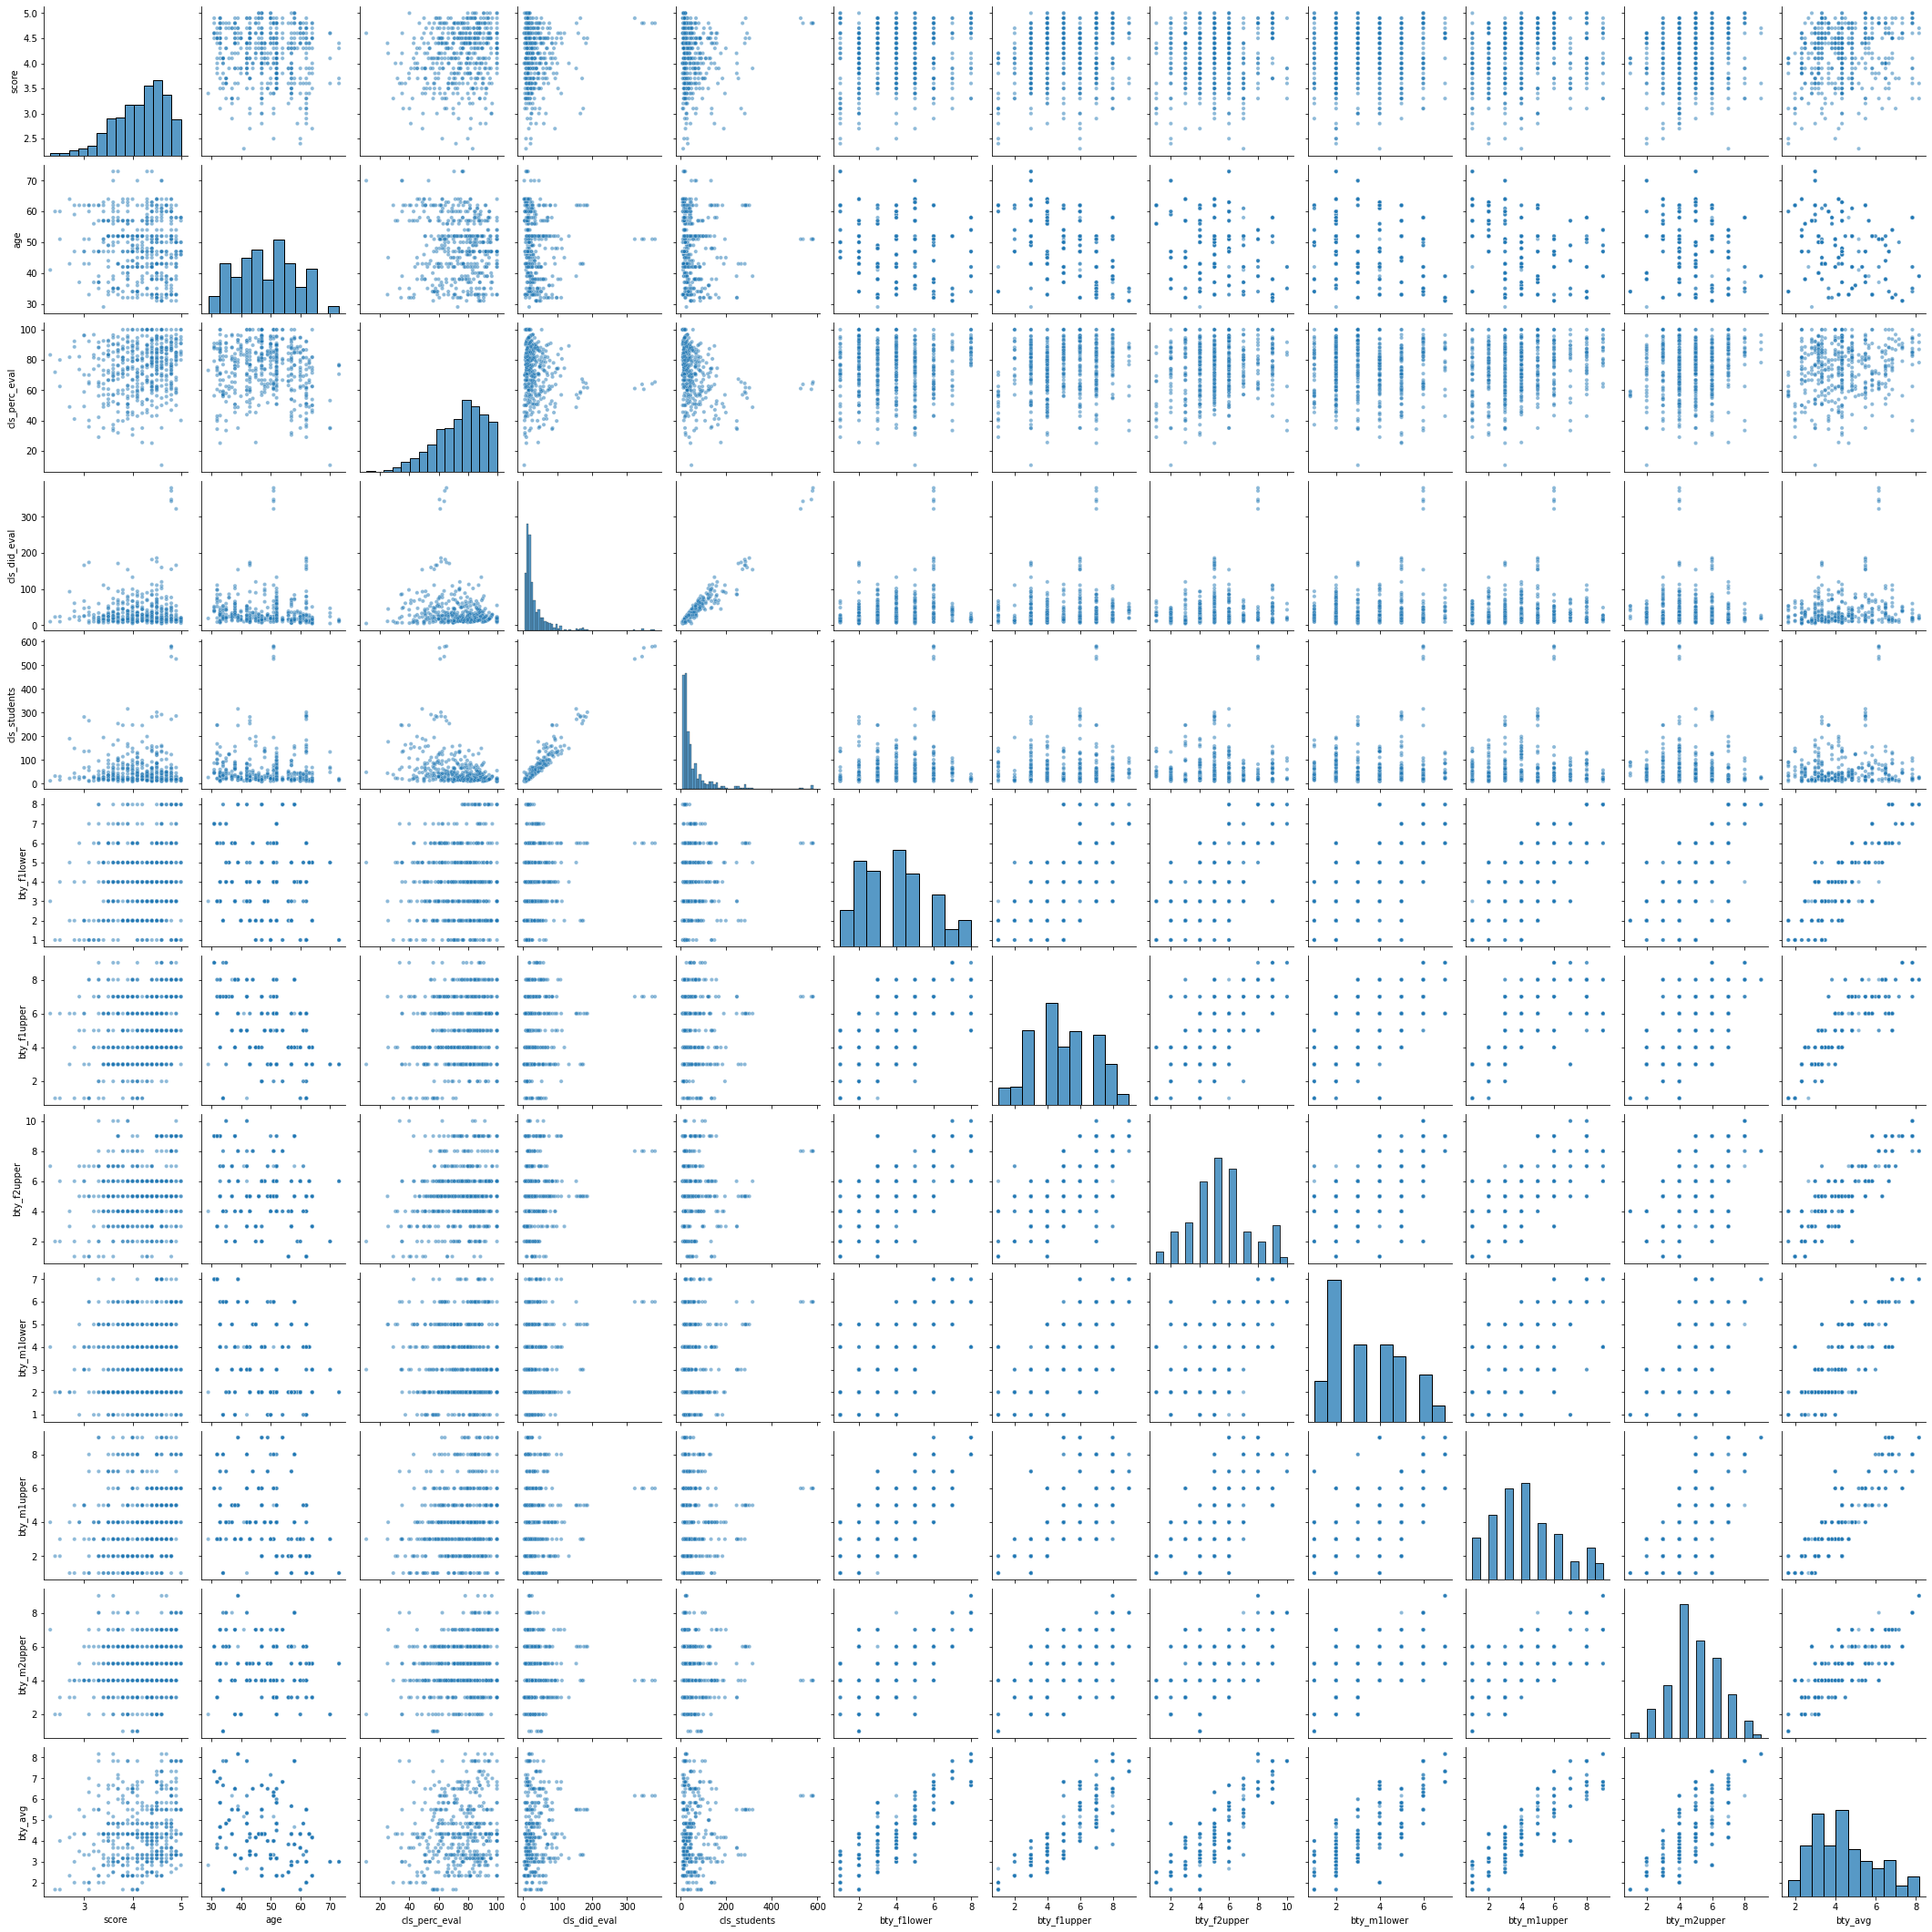

In [ ]:
sns.pairplot(df, plot_kws={'alpha':0.5, 'size': 0.1})

With so many numeric variables, the pair plot is hard to read. We can
create a pairplot excluding some variables that we don’t expect to be
useful for visualization: `cls_perc_eval`, `cls_did_eval`. We will also
exclude the individual attractiveness ratings `bty_f1lower`,
`bty_f1upper`, `bty_f2upper`, `bty_m1lower`, `bty_m1upper`,
`bty_m2upper`, since the overall attractiveness rating is still
represented by `bty_avg`.

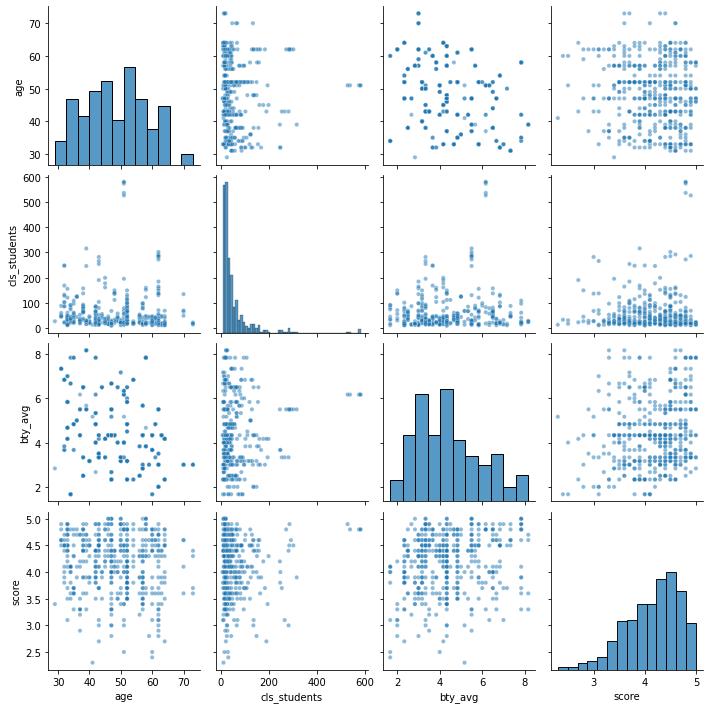

In [ ]:
sns.pairplot(df, vars=['age', 'cls_students', 'bty_avg', 'score'], plot_kws={'alpha':0.5, 'size': 0.1})

As part of our exploration of the data, we can also examine the effect
of non-numeric variables related to the instructor and the class:
`rank`, `ethnicity`, `gender`, `language`, `cls_level`, `cls_profs`,
`cls_credits`.

In [ ]:
for feature in ['rank', 'ethnicity', 'gender', 'language', 'cls_level', 'cls_profs', 'cls_credits']:
    df.groupby([feature])['score'].describe()

,count,mean,std,min,25%,50%,75%,max
rank,,,,,,,,
teaching,102.0,4.284314,0.498263,3.3,3.9,4.40,4.7,5.0
tenure track,108.0,4.154630,0.561104,2.3,3.7,4.35,4.6,4.9
tenured,253.0,4.139130,0.550262,2.4,3.8,4.20,4.6,5.0


,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
minority,64.0,4.071875,0.581588,2.7,3.675,4.05,4.525,5.0
not minority,399.0,4.191228,0.536505,2.3,3.850,4.30,4.600,5.0


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,195.0,4.092821,0.563814,2.3,3.7,4.1,4.5,5.0
male,268.0,4.234328,0.521896,2.4,3.9,4.3,4.6,5.0


,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
english,435.0,4.189655,0.547183,2.3,3.9,4.30,4.6,5.0
non-english,28.0,3.942857,0.434979,3.4,3.6,3.75,4.4,4.8


,count,mean,std,min,25%,50%,75%,max
cls_level,,,,,,,,
lower,157.0,4.238217,0.592532,2.5,3.8,4.4,4.7,5.0
upper,306.0,4.142157,0.515104,2.3,3.8,4.2,4.5,5.0


,count,mean,std,min,25%,50%,75%,max
cls_profs,,,,,,,,
multiple,306.0,4.184641,0.551177,2.4,3.8,4.3,4.6,5.0
single,157.0,4.155414,0.530529,2.3,3.8,4.3,4.6,5.0


,count,mean,std,min,25%,50%,75%,max
cls_credits,,,,,,,,
multi credit,436.0,4.147018,0.542464,2.3,3.8,4.2,4.6,5.0
one credit,27.0,4.622222,0.334357,3.5,4.5,4.7,4.9,5.0


#### Question 1

Describe the relationship between `score` and the overall attractiveness
rating `bty_avg`. Is there an apparent correlation? If so, is it a
positive or a negative correlation? What about `age` and `cls_students`,
do they appear to be correlated with `score`?

Also describe the relationship between `score` and the categorical
variables you explored above that are related to characteristics of the
*instructor*: `rank`, `ethnicity`, `gender`, `language`. Which of these
variables have a potential correlation with `score`? Is it a positive or
a negative correlation?

Are any of the apparent relationships you observed unexpected to you?
Explain.

------------------------------------------------------------------------

### Encoding categorical variables

For *one hot encoding* of categorical variables, we can use the
`get_dummies` function in `pandas`. Create a copy of the dataframe with
all categorical variables transformed into indicator (“dummy”)
variables, and save it in a new data frame called `df_enc`. Compare the
columns of the `df` data frame versus the `df_enc` data frame.

In [ ]:
df_enc = pd.get_dummies(df)
df_enc.columns

Index(['score', 'age', 'cls_perc_eval', 'cls_did_eval', 'cls_students',
       'bty_f1lower', 'bty_f1upper', 'bty_f2upper', 'bty_m1lower',
       'bty_m1upper', 'bty_m2upper', 'bty_avg', 'rank_teaching',
       'rank_tenure track', 'rank_tenured', 'ethnicity_minority',
       'ethnicity_not minority', 'gender_female', 'gender_male',
       'language_english', 'language_non-english', 'cls_level_lower',
       'cls_level_upper', 'cls_profs_multiple', 'cls_profs_single',
       'cls_credits_multi credit', 'cls_credits_one credit',
       'pic_outfit_formal', 'pic_outfit_not formal', 'pic_color_black&white',
       'pic_color_color'],
      dtype='object')

In [ ]:
df_enc.head()

,score,age,cls_perc_eval,cls_did_eval,cls_students,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,bty_m2upper,bty_avg,rank_teaching,rank_tenure track,rank_tenured,ethnicity_minority,ethnicity_not minority,gender_female,gender_male,language_english,language_non-english,cls_level_lower,cls_level_upper,cls_profs_multiple,cls_profs_single,cls_credits_multi credit,cls_credits_one credit,pic_outfit_formal,pic_outfit_not formal,pic_color_black&white,pic_color_color
0,4.7,36,55.81395,24,43,5,7,6,2,4,6,5.0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1
1,4.1,36,68.80000,86,125,5,7,6,2,4,6,5.0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1
2,3.9,36,60.80000,76,125,5,7,6,2,4,6,5.0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1
3,4.8,36,62.60163,77,123,5,7,6,2,4,6,5.0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1
4,4.6,59,85.00000,17,20,4,4,2,2,3,3,3.0,0,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0,1,0,1


### Split data

Next, we split the encoded data into a training set (70%) and test set
(30%). We will be especially interested in evaluating the model
performance on the test set. Since it was not used to train the model
parameters (intercept and coefficients), the performance on this data
gives us a better idea of how the model may perform on new data.

We’ll use the `train_test_split` method in `sklearn`’s `model_selection`
module. Since it randomly splits the data, we’ll pass a random “state”
into the function that makes the split repeatable (same split every time
we run this notebook) and ensures that everyone in the class will have
exactly the same split.

In [ ]:
train, test = model_selection.train_test_split(df_enc, test_size=0.3, random_state=9)
# why 9? see https://dilbert.com/strip/2001-10-25
train.shape
test.shape

(324, 31)

(139, 31)

### Simple linear regression

Now we are finally ready to train a regression model.

Since the article is nominally abou the attractiveness of the
instructor, we will train the simple linear regression on the `bty_avg`
feature.

In the cell that follows, we will write code to

-   use `sklearn` to fit a simple linear regression model on the
    training set, using `bty_avg` as the feature on which to train. Save
    your fitted model in a variable `reg_simple`.
-   print the intercept and coefficient of the model.
-   use `predict` on the fitted model to estimate the evaluation score
    on the training set, and save this array in `y_pred_train`.
-   use `predict` on the fitted model to estimate the evaluation score
    on the test set, and save this array in `y_pred_test`.

Then run the cell after that one, which will show you the training data,
the test data, and your regression line.

In [ ]:
reg_simple = LinearRegression().fit(train[['bty_avg']], train['score'])
reg_simple.coef_
reg_simple.intercept_

y_pred_train = reg_simple.predict(train[['bty_avg']])
y_pred_test = reg_simple.predict(test[['bty_avg']])


array([0.07367795])

3.842544653270748

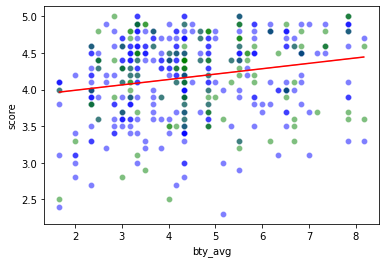

In [ ]:
sns.scatterplot(data=train, x="bty_avg", y="score", color='blue', alpha=0.5);
sns.scatterplot(data=test, x="bty_avg", y="score", color='green', alpha=0.5);
sns.lineplot(data=train, x="bty_avg", y=y_pred_train, color='red');

### Evaluate simple linear regression performance

Now we will evaluate our model performance.

In the following cell, we will write a *function* to compute key performance
metrics for your model:

-   compute the R2 score on the training data, and print it
-   compute the MSE on the training data, and print it
-   compute the MSE, divided by the sample variance of
    `score`, on the training data, and print it. Recall that this
    metric tells us the ratio of average error of the model to average
    error of prediction by mean.
-   and compute the same three metrics for the test set

In [ ]:
def print_regression_performance(y_true_train, y_pred_train, y_true_test, y_pred_test):
    r2_train = metrics.r2_score(y_true_train, y_pred_train)
    rss_per_sample_train = metrics.mean_squared_error(y_true_train, y_pred_train)
    norm_rss_train = metrics.mean_squared_error(y_true_train, y_pred_train)/(np.std(y_true_train)**2)

    r2_test = metrics.r2_score(y_true_test, y_pred_test)
    rss_per_sample_test = metrics.mean_squared_error(y_true_test, y_pred_test)
    norm_rss_test = metrics.mean_squared_error(y_true_test, y_pred_test)/(np.std(y_true_test)**2)

    print("Training:   %f %f %f" % (r2_train, rss_per_sample_train, norm_rss_train))
    print("Test: %f %f %f" % (r2_test, rss_per_sample_test, norm_rss_test))

Call your function to print the performance of the simple linear
regression. Is a simple linear regression on `bty_avg` better than a
“dumb” model that predicts the mean value of `score` for all samples?

In [ ]:
print_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)

Training:   0.042169 0.287122 0.957831
Test: 0.011239 0.279965 0.988761


### Multiple linear regression

Next, we’ll see if we can improve model performance using multiple
linear regression, with more features included.

To start, we need to decide which features to use as input to our model.
One possible approach is to use every feature in the dataset excluding
the target variable, `score`.

You can build and view this list of features by running:

In [ ]:
features = df_enc.columns.drop(['score'])
features

Index(['age', 'cls_perc_eval', 'cls_did_eval', 'cls_students', 'bty_f1lower',
       'bty_f1upper', 'bty_f2upper', 'bty_m1lower', 'bty_m1upper',
       'bty_m2upper', 'bty_avg', 'rank_teaching', 'rank_tenure track',
       'rank_tenured', 'ethnicity_minority', 'ethnicity_not minority',
       'gender_female', 'gender_male', 'language_english',
       'language_non-english', 'cls_level_lower', 'cls_level_upper',
       'cls_profs_multiple', 'cls_profs_single', 'cls_credits_multi credit',
       'cls_credits_one credit', 'pic_outfit_formal', 'pic_outfit_not formal',
       'pic_color_black&white', 'pic_color_color'],
      dtype='object')

In the following cell, write code to

-   use `sklearn` to fit a linear regression model on the training set,
    using the `features` array as the list of features to train on. Save
    your fitted model in a variable `reg_multi`.
-   print a table of the features used in the regression and the
    coefficient assigned to each. If you have saved your fitted
    regression in a variable named `reg_multi`, you can create and print
    this table with:

``` python
df_coef = pd.DataFrame(data =
                        {'feature': features,
                         'coefficient': reg_multi.coef_})
df_coef
```

In [ ]:
reg_multi = LinearRegression().fit(train[features], train['score'])
df_coef = pd.DataFrame(data =
                        {'feature': features,
                         'coefficient': reg_multi.coef_})
df_coef

,feature,coefficient
0,age,-0.009493
1,cls_perc_eval,0.004385
2,cls_did_eval,0.002983
3,cls_students,-0.001427
4,bty_f1lower,7.022264
5,bty_f1upper,7.052930
6,bty_f2upper,7.032261
7,bty_m1lower,6.959419
8,bty_m1upper,6.999172
9,bty_m2upper,6.978719


#### Question 2

Look at the list of features and coefficients, especially those related
to the attractiveness ratings.

Are these results surprising, based on the results of the simple linear
regression? Explain your answer.



### Effect of collinearity

Note especially the coefficients associated with each of the individual
attractiveness rankings, and the coefficient associated with the average
attractiveness ranking. Each of these features separately seems to have
a large effect; however, because they are strongly *collinear*, they
cancel one another out.

(You should be able to see the collinearity clearly in the pairplot you
created.)

In the following cell, we will write code to

-   create a new `features` array, that drops the *individual*
    attractiveness rankings in addition to the `score` variable (but do
    *not* drop the average attractiveness ranking)
-   use `sklearn` to fit a linear regression model on the training set,
    using the new `features` array as the list of features to train on.
    Save your fitted model in a variable `reg_avgbty`.
-   print a table of the features used in the regression and the
    coefficient assigned to each.

In [ ]:
features = df_enc.columns.drop(['score',
    'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
    'bty_m1lower', 'bty_m1upper', 'bty_m2upper'])
reg_avgbty = LinearRegression().fit(train[features], train['score'])

df_coef = pd.DataFrame(data =
                        {'feature': features,
                         'coefficient': reg_avgbty.coef_})
df_coef

,feature,coefficient
0,age,-0.009297
1,cls_perc_eval,0.004900
2,cls_did_eval,0.003737
3,cls_students,-0.001740
4,bty_avg,0.040577
5,rank_teaching,0.075283
6,rank_tenure track,-0.059429
7,rank_tenured,-0.015854
8,ethnicity_minority,-0.111830
9,ethnicity_not minority,0.111830


#### Question 3

Given the model parameters you have found, which seems to have the stronger effect on teaching score?

-   Instructor ethnicity
-   Instructor gender

(Note that in general, we cannot use the coefficient to compare the
effect of features on different scales. Both ethnicity and
gender are represented by binary one hot-encoded variables.)

---

In this data, instructor ethnicity seems to have stronger effect than instructor gender.



**Stopped here on June 18, 2020**

---



### Evaluate multiple regression model performance

Evaluate the performance of your `reg_avgbty` model. In the next cell, we will
write code to:

-   use the `predict` function on the fitted regression to find
  $\hat{y}$ for all samples in the *training* set, and save this in an
    array called `y_pred_train`
-   use the `predict` function on your fitted regression to find
  $\hat{y}$ for all samples in the *test* set, and save this in an
    array called `y_pred_test`
-   call the `print_regression_performance` function we wrote in a
    previous cell, and print the performance metrics on the training and
    test set.

In [ ]:
# y_pred_train = ...
# y_pred_test = ...

y_pred_train = reg_avgbty.predict(train[features])
y_pred_test = reg_avgbty.predict(test[features])

print_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)

Training:   0.210850 0.236558 0.789150
Test: 0.109995 0.252002 0.890005


#### Question 4

Based on the analysis above, what portion of the variation in instructor
teaching evaluation can be explained by the factors unrelated to
teaching performance, such as the physical characteristics of the
instructor?


---

* Training data: FVU is ~0.8, so about 20% of the variance is explained by these features.
* Test data: FVU is ~0.9, so about 10% of the variance is explained by these features.


#### Question 5

Based on the analysis above, is your model better at predicting
instructor teaching scores than a “dumb” model that just assigns the
mean teaching score to every instructor? Explain.

---

Yes, our model is better than prediction by mean (ratio of error of our model to error of prediction by mean is less than 1).


#### Question 6

Suppose you are hired by the ECE department to develop a classifer that
will identify high-performing faculty, who will then be awarded prizes
for their efforts.

Based on the analysis above, which approach do you think would be better:

* Give a prize to all instructors who achieve above-average teaching scores.
* Give a prize to all instructors who achieve teaching scores higher than what the linear regression model predicts they should achieve, based on physical characteristics and course characteristics.

---

* On the one hand, if students are giving higher scores to more attractive professors, is it really fair to compare all instructors to the same standard?
* It's possible that there is a relationship between attractiveness and teaching effectiveness - for example, young professors are more attractive and also more engaging. But age did not have as strong an effect.
* On the other hand, it doesn't seem fair to hold different people to different standards.
* Important to realize that the prediction of the model has a lot of error.


### Exploring unexpected correlation

There are some features that we do *not* expect to be correlated with
the instructor’s score.

For example, consider the “features” related to the photograph used by
the students who rated the instructor’s attractiveness.

There is no reason that characteristics of an instructor’s photograph -
whether it was in black and white or color, how the instructor was
dressed in the photograph - should influence the ratings of students in
the instructor’s class. These students most likely did not even see the
photograph.

In the next cell, we will write code to

-   create a new `features` array that drops the `score` variable, all
    of the individual attractiveness rankings, and the variables related
    to the photograph used for attractiveness rankings.
-   use it to fit a model (saved in `reg_nopic`).
-   use `reg_nopic` to predict the evaluation scores on both the
    training and test set
-   compute the same set of metrics as above.

In [ ]:
# features = ...
# reg_nopic = ...

features = df_enc.columns.drop(['score',
    'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
    'bty_m1lower', 'bty_m1upper', 'bty_m2upper',
    'pic_outfit_formal', 'pic_outfit_not formal',
    'pic_color_black&white', 'pic_color_color'])

reg_nopic = LinearRegression().fit(train[features], train['score'])


y_pred_train = reg_nopic.predict(train[features])
y_pred_test = reg_nopic.predict(test[features])

print_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)


Training:   0.196337 0.240908 0.803663
Test: 0.063476 0.265174 0.936524


#### Question 7

Is the model less predictive when features related to the instructor
photograph are excluded? Explain.

---

The model is less predictive (lower R2) when we exclude features related to the instructor photograph.


Finally, we will observe the effect of excluding class-related variables
(whether it is an upper-division or lower-division class, number of
credits, etc.)

In the next cell, we will write code to:

-   create a new `features` array that drops the `score` variable, all
    of the individual attractiveness rankings, the variables related to
    the photograph used for attractiveness rankings, *and* all of the
    variables that begin with the `cls` prefix.
-   use it to fit a model (saved in `reg_nocls`).
-   use `reg_nocls` to predict the evaluation scores on both the
    training and test set
-   compute the same set of metrics as above.

In [ ]:
# features = ...
# reg_nocls = ...

features = df_enc.columns.drop(['score',
    'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
    'bty_m1lower', 'bty_m1upper', 'bty_m2upper',
    'pic_outfit_formal', 'pic_outfit_not formal',
    'pic_color_black&white', 'pic_color_color',
    'cls_credits_multi credit', 'cls_credits_one credit',
    'cls_profs_multiple', 'cls_profs_single',
    'cls_perc_eval', 'cls_did_eval', 'cls_students',
    'cls_level_lower', 'cls_level_upper'])

reg_nocls = LinearRegression().fit(train[features], train['score'])

y_pred_train = reg_nocls.predict(train[features])
y_pred_test = reg_nocls.predict(test[features])

print_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)

Training:   0.111649 0.266294 0.888351
Test: 0.044442 0.270563 0.955558


When a machine learning model seems to use a feature that is not
expected to be correlated with the target variable (such as the
characteristics of the instructor’s photograph…), this can sometimes be
a signal that information is “leaking” between the training and test
set.

In this dataset, each row represents a single course. However, some
instructors teach more than one course, and an instructor might get
similar evaluation scores on all of the courses he or she teaches.
(According to the paper for which this dataset was collected, 94 faculty
members taught the 463 courses represented in the dataset, with some
faculty members teaching as many as 13 courses.)

For example, consider the output of the following command, which prints
all of the one credit courses in the data:

In [ ]:
df.loc[df['cls_credits']=='one credit']

,score,rank,ethnicity,gender,language,age,cls_perc_eval,cls_did_eval,cls_students,cls_level,cls_profs,cls_credits,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,bty_m2upper,bty_avg,pic_outfit,pic_color
124,3.5,teaching,not minority,female,english,52,89.47369,17,19,upper,multiple,one credit,6,6,4,2,4,7,4.833,not formal,color
179,4.4,tenure track,minority,female,english,47,100.00000,16,16,lower,single,one credit,2,6,6,3,5,4,4.333,not formal,color
185,4.6,tenure track,minority,female,english,47,95.23810,20,21,lower,single,one credit,2,6,6,3,5,4,4.333,not formal,color
245,4.2,teaching,not minority,female,english,50,75.00000,24,32,lower,single,one credit,2,3,5,2,3,4,3.167,not formal,color
246,4.7,teaching,not minority,female,english,50,66.66666,14,21,lower,single,one credit,2,3,5,2,3,4,3.167,not formal,color
339,4.8,tenure track,not minority,male,english,43,53.57143,15,28,lower,multiple,one credit,3,4,4,2,4,4,3.500,not formal,color
340,4.9,tenure track,not minority,male,english,43,60.00000,18,30,lower,multiple,one credit,3,4,4,2,4,4,3.500,not formal,color
343,4.5,tenure track,not minority,male,english,43,94.44444,17,18,lower,multiple,one credit,3,4,4,2,4,4,3.500,not formal,color
344,4.9,tenure track,not minority,male,english,43,84.61539,22,26,lower,multiple,one credit,3,4,4,2,4,4,3.500,not formal,color
345,4.4,tenure track,not minority,male,english,43,60.00000,18,30,lower,multiple,one credit,3,4,4,2,4,4,3.500,not formal,color


We observe that 10 out of 27 one-credit courses are taught by what seems
to be the same instructor - an individual who is a teaching-track
professor, minority ethnicity, male, English-language trained, 50 years
old, average attractiveness 3.333, and whose photograph is in color and
not formal.

This provides a clue regarding the apparent importance of the
`cls_credits` variable and other “unexpected” variables in predicting
the teaching score. Certain variables may be used by the model to
identify the instructor and then learn a relationship between the
individual instructor and his or her typical evaluation score, instead
of learning a true relationship between the variable and the evaluation
score.

To explore this issue further, we will repeat our analysis using two
different ways of splitting the dataset:

1.  random split
2.  random split that ensures that each individual *instructor* is
    represented in the training data or the test data, but not both.

In the latter case, if the regression model is effectively identifying
individual instructors, rather than learning true relationships between
instructor/course characteristics and teaching ratings, then the model
will perform much worse on the test set for this type of split. This is
because the instructors it has “learned” are not present in the test
set.

First, we will assign an “instructor ID” to each row in our data frame:

In [ ]:
instructor_id = df[['rank', 'ethnicity', 'gender', 'language',
        'pic_outfit', 'pic_color']].agg('-'.join, axis=1)
instructor_id +=  '-' + df['age'].astype(str)
instructor_id +=  '-' + df['bty_avg'].astype(str)

df_enc = df_enc.assign(instructor_id = instructor_id)

df_enc['instructor_id'].head()

0    tenure track-minority-female-english-not forma...
1    tenure track-minority-female-english-not forma...
2    tenure track-minority-female-english-not forma...
3    tenure track-minority-female-english-not forma...
4    tenured-not minority-male-english-not formal-c...
Name: instructor_id, dtype: object

In [ ]:
len(pd.unique(df_enc['instructor_id']))

95

Now we will perform our splits, train a model, and print performance
metrics according to the first scheme, in which an instructor may be
present in both the training set and the test set.

In the following cell, add code as indicated:

In [ ]:
def return_regression_performance(y_true_train, y_pred_train, y_true_test, y_pred_test):
    r2_train = metrics.r2_score(y_true_train, y_pred_train)
    rss_per_sample_train = metrics.mean_squared_error(y_true_train, y_pred_train)
    norm_rss_train = metrics.mean_squared_error(y_true_train, y_pred_train)/(np.std(y_true_train)**2)

    r2_test = metrics.r2_score(y_true_test, y_pred_test)
    rss_per_sample_test = metrics.mean_squared_error(y_true_test, y_pred_test)
    norm_rss_test = metrics.mean_squared_error(y_true_test, y_pred_test)/(np.std(y_true_test)**2)

    return [r2_train, rss_per_sample_train, norm_rss_train, r2_test, rss_per_sample_test, norm_rss_test]


In [ ]:
metrics_ss = np.zeros((10, 6))

ss = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, random_state=9)

i = 0

for train_idx, test_idx in ss.split(df_enc):
    train = df_enc.iloc[train_idx]
    test = df_enc.iloc[test_idx]

    features = df_enc.columns.drop(['score', 'instructor_id'])
    print('----')

    # TODO: add code to train a multiple linear regression using
    # the train dataset and the list of features created above
    # save the fitted model in reg_rndsplit
    # then use the model to create y_pred_train and y_pred_test,
    # the model predictions on the training set and test set.
    # Finally, use print_regression_performance to see the
    # model performance
    #
    # reg_rndsplit = ...
    # y_pred_train = ...
    # y_pred_test = ...

    reg_rndsplit = LinearRegression().fit(train[features], train['score'])

    y_pred_train = reg_rndsplit.predict(train[features])
    y_pred_test = reg_rndsplit.predict(test[features])

    print_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)
    metrics_ss[i] = return_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)
    i = i+1

----
Training:   0.236093 0.228991 0.763907
Test: 0.119244 0.249383 0.880756
----
Training:   0.265081 0.223358 0.734919
Test: -0.023449 0.278695 1.023449
----
Training:   0.245462 0.223202 0.754538
Test: 0.057313 0.276311 0.942687
----
Training:   0.225740 0.210693 0.774260
Test: 0.157478 0.293672 0.842522
----
Training:   0.162853 0.218767 0.837147
Test: 0.212516 0.291072 0.787484
----
Training:   0.229378 0.234672 0.770622
Test: 0.111535 0.241653 0.888465
----
Training:   0.214897 0.227347 0.785103
Test: 0.149954 0.261655 0.850046
----
Training:   0.226463 0.228695 0.773537
Test: 0.112516 0.259632 0.887484
----
Training:   0.241330 0.216706 0.758670
Test: 0.093933 0.287412 0.906067
----
Training:   0.196566 0.234145 0.803434
Test: 0.194787 0.244202 0.805213


In [ ]:
np.mean(metrics_ss, axis=0)

array([0.22438618, 0.22465758, 0.77561382, 0.11858273, 0.26836861,
       0.88141727])

Then, we will perform our splits, train a model, and print performance
metrics according to the second scheme, in which an instructor may be
present in either the training set or the test set, but not both.

In the following cell, add code as indicated:

In [ ]:
metrics_gss = np.zeros((10, 6))
i = 0

gss = model_selection.GroupShuffleSplit(n_splits=10, test_size=0.3, random_state=9)
for train_idx, test_idx in gss.split(df_enc, groups=instructor_id):
    train = df_enc.iloc[train_idx]
    test = df_enc.iloc[test_idx]

    features = df_enc.columns.drop(['score', 'instructor_id'])

    # TODO: add code to train a multiple linear regression using
    # the train dataset and the list of features created above
    # save the fitted model in reg_grpsplit
    # then use the model to create y_pred_train and y_pred_test,
    # the model predictions on the training set and test set.
    # Finally, use print_regression_performance to see the
    # model performance
    #
    # reg_grpsplit = ...
    # y_pred_train = ...
    # y_pred_test = ...

    reg_grpsplit = LinearRegression().fit(train[features], train['score'])

    y_pred_train = reg_grpsplit.predict(train[features])
    y_pred_test = reg_grpsplit.predict(test[features])

    print_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)
    metrics_gss[i] = return_regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)
    i = i+1

Training:   0.266158 0.227850 0.733842
Test: -0.108004 0.289910 1.108004
Training:   0.282000 0.203818 0.718000
Test: -0.197594 0.368528 1.197594
Training:   0.290361 0.205339 0.709639
Test: -0.161510 0.335828 1.161510
Training:   0.281277 0.216566 0.718723
Test: -0.170325 0.330167 1.170325
Training:   0.319919 0.198729 0.680081
Test: -0.647968 0.486751 1.647968
Training:   0.176171 0.231061 0.823829
Test: 0.047797 0.299241 0.952203
Training:   0.300483 0.220839 0.699517
Test: -0.904934 0.446599 1.904934
Training:   0.287227 0.201532 0.712773
Test: -0.147132 0.372595 1.147132
Training:   0.324288 0.188021 0.675712
Test: -0.278453 0.431646 1.278453
Training:   0.273141 0.216596 0.726859
Test: -0.146815 0.329260 1.146815


In [ ]:
np.mean(metrics_gss, axis=0)

array([ 0.28010256,  0.21103509,  0.71989744, -0.27149368,  0.36905241,
        1.27149368])

#### Question 8

Based on the analysis above, do you think the model will be useful to
predict the teaching evaluation scores of a new faculty member at UT
Austin, based on his or her physical characteristics and the
characteristics of the course?

---

No! This model does not generalize at all. When we use truly independent training set and test set, we see that our model actually performs worse than "prediction by mean" on the new, unseen data.

### Data leakage

In this case study, we saw evidence of data leakage: The identity of the instructor "leaked" into the data set, and then the model learned the instructor ID, not a true relationship between instructor characteristics and teaching evaluation scores.

As a result, the model had overly optimistic error on the test set. The model appeared to generalize to new, unseen, data, but in fact would not generalize to different instructors.




Another example of data leakage:


You have been hired to develop a new spam classifier for NYU Tandon email. To collect a dataset for the spam classification task, you get 5,000 NYU Tandon students, faculty, and staff who agree to manually label every email they receive for the week of March 15-March 21 as "spam" (about 5\%) or "not spam" (about 95\%). They then share all the emails and labels with you. For example, here are a few of the emails you got from Volunteer 1, who is a member of the ECE department:


| Subject | From | To | Label |
|--- | --- | --- | --- |
| April Funding Opportunities | Office of Sponsored Programs | All Tandon Faculty | Not Spam |
| ML TA meeting next week | Student 23451 (redacted) | Fraida Fund | Not Spam |
| Pass/fail option for students this semester | Ivan Selesnick | ECE Faculty | Not Spam |
| A question about quiz1 | Student 19245 (redacted) | Fraida Fund | Not Spam |
| Re: your account is locked | PayPall | Fraida Fund | Spam |
| Fwd: Gradescope Webinar | Ivan Selesnick | ECE Faculty | Not Spam |
| Memo to Faculty on COVID-19 Protocols | Provost Katherine Fleming |All Tandon Faculty | Not Spam |



You assign the emails from volunteers 1-2,500 to a training set and use it to fit a classifier, then compute the classifier accuracy on the emails from volunteers 2,501-5,000.

Your classifier does really well on the emails from volunteers 2,501-5,000 - in fact, it is 99.9999\% accurate! But when you deploy it in production, it misses a lot of spam. Based on the description above, what mistake did you make that caused your performance estimate to be overly optimistic? How would you fix it?


Also potential for data leakage when:

* Learning from adjacent temporal data
* Learning from data that includes duplicate
* Learning from a feature that is a proxy for target variable


How can we detect data leakage?

* Surprising patterns in data (via exploratory data analysis)
* Performance is "too good to be true"
* Features that shouldn't be important (based on common sense/domain knowledge) play a role in reducing error
* Early testing in production
